In [1]:
import netCDF4 as nc
import numpy as np
from numpy.linalg import svd , eig, inv
import scipy.stats as stats
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import cmocean

from plotting import *

In [3]:
#files on disk
mask_full_file = './data/omega_upward_mask_2020_full.npy'

#variable files on disk
lon_file = './data/lon.npy'
lat_file = './data/lat.npy'
p_file = './data/p.npy'
time_file = './data/time.npy'

#constants
monmax = 468
monmax_sub = 117
lonmax = 240
p_levels = 28

lat1 = 20
lat2 = -20
lat_lims = [lat1, lat2]

#set colormap
colormap = cmocean.cm.balance

#left and right title names
left_title = '-$\omega$ Mask'
eof_title = ', EOF '
all_months = ', All Months'

right_title = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

In [5]:
#load files
mask_full = np.load(mask_full_file)

lon = np.load(lon_file)
lat = np.load(lat_file)
p = np.load(p_file)
time = np.load(time_file)

#replace NaNs with zeros for autocorrelation and DOF calculation
mask_full[np.where(np.isnan(mask_full))] = 0

The shape of our data is (time, pressure, longitude). In a previous Notebook I weighted our upward pressure velocity mask arrays by cos(latitude) for [20N, 20S] and then averaged over that dimension.

In [6]:
print(mask_full.shape)

(468, 28, 240)


In [7]:
#instead of dimensions (time, pressure, longitude), we want (pressure, time, longitude)
mask_full_p = np.transpose(mask_full, (1, 0, 2))

#subset pressure levels to match seasonal mask
p = p[p>=70]

Now we are going to subset for one particular pressure level (about half way up) so that when we are calculating the degrees of freedom we only have to take into account one variable. If we kept pressure, we would need to calculate degrees of freedom for both time and longitude and then combine them somehow.

In [8]:
#subset the full mask at 500 mb for autocorrelation computation
mask_full_500 = mask_full_p[12, :, :]

In [9]:
#(time, longitude)
print(mask_full_500.shape)

(468, 240)


Below, I am going to calculate and then plot the EOFs of this matrix in terms of pressure, to determine which pressures (across all months or a subset of months) explain the most variance. To do so, I will need to follow these steps:
- Calculate degrees of freedom from Bretherton et al. (1999): $\frac{N^*}{N} = \frac{1-r(\Delta t)^2}{1+r(\Delta t)^2}$, where $r \Delta (t)$ is the autocorrelation function
- Perform Eigen Analysis on the covariance matrix of (pressure, longitude)
- Plot eigenvalue spectrum, which is $\sigma_i$, where $\sigma^2_i = \lambda_i n$
- Put error bars (confidence limits) on eigenvalue spectrum from North et al. criterion: $\Delta \lambda = \lambda \sqrt{\frac{2}{N^*}}$

Then we can determine which EOFs are independent from the eigenvalue spectrum by looking to see if their error bars overlap.

### Autocorrelation and DOF

In [10]:
#create matrices that are 1 month apart
mask1 = mask_full_500[:-1]
mask2 = mask_full_500[1:]

#autocorrelation of sst for one month time lag
#element-wise multiply our two 1-month lag matrices, sum over all dimensions
top = np.sum(np.multiply(mask1, mask2))

#element-wise multiply the sum of the squared 1-month time lag matrices, take square root
bottom = np.sqrt(np.multiply(np.sum(mask1**2), np.sum(mask2**2)))

#calculate autocorrelation
autt = top / bottom

#calculate degrees of freedom for all months
dof = monmax * (1 - autt*autt) / (1 + autt*autt)

In [11]:
#autocorrelation should be much bigger
print('Autocorrelation:    ', np.round(autt, 5))
print('Degrees of freedom: ', np.round(dof, 5))

Autocorrelation:     0.84012
Degrees of freedom:  80.71688


### EOFs Through Covariance Matrix

In [12]:
#flatten the array
mask_reshape_p = np.reshape(mask_full_p, (p_levels, -1))

#sample size is time * longitude
C = np.matmul(mask_reshape_p, mask_reshape_p.T) / (lonmax * monmax_sub)

In [13]:
#so now our covariance matrix is only in terms of pressure
C.shape

(28, 28)

Here is are some handy things to keep in mind when doing EOF analysis, how we can get from the covariance matrix to our EOFs, and then determine how those EOFs are independent.

- EOFs are the eigenvectors of a covariance matrix 

- the eigenvalues are ordered by size, and measure the variance explained by each eigenvector

- The eigenvectors are orthogonal in the structure dimension.

- The principal components are uncorrelated in the sampling dimension (double orthogonality)

- So no variance is shared between eigenvectors, we get the total variance explained by summing the eigenvalues.

In [14]:
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html
#w: The eigenvalues, each repeated according to its multiplicity. 
#v: The normalized (unit “length”) eigenvectors
eigvals, eigvectors = eig(C)

#calculate error bars
total_eig = np.sum(eigvals)
total_var = eigvals / total_eig
delta = total_var * np.sqrt(2 / dof)

In [16]:
#print how much variance each EOF explains
print([np.round(float(var), 6) for var in total_var])

[0.914001, 0.041599, 0.015975, 0.008163, 0.006136, 0.003525, 0.002393, 0.001609, 0.001203, 0.000889, 0.000713, 0.000564, 0.000469, 6e-06, 0.000413, 3.7e-05, 5.1e-05, 0.000356, 8.1e-05, 9.6e-05, 0.000137, 0.000141, 0.000173, 0.000205, 0.000228, 0.000302, 0.000279, 0.000257]


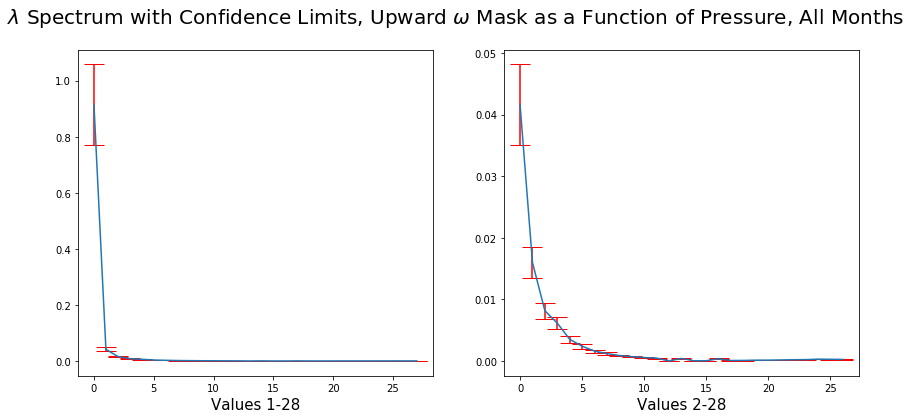

In [17]:
#plot the singular value spectrum with error bars
figure, axis = plt.subplots(1, 2, figsize=(14, 6))

#plot eigenvalues as a fraction of total variance
axis[0].errorbar(np.arange(0, 28), total_var[:28], yerr=delta[:28], ecolor='r', capsize=10)
axis[1].errorbar(np.arange(0, 27), total_var[1:28], yerr=delta[1:28], ecolor='r', capsize=10)

axis[0].set_title('')
axis[1].set_title('')

#add title
figure.suptitle('$\lambda$ Spectrum with Confidence Limits, Upward $\omega$ Mask as a Function of Pressure, All Months', fontsize=20)

#set x labels
axis[0].set_xlabel('Values 1-28', fontsize=15)
axis[1].set_xlabel('Values 2-28', fontsize=15)

plt.show()

So: the first 3 EOFs are most likely independent. However, the first EOF explains more than 90% of the variance which is not ideal. We would like the number to be high, but it would be nice if the second EOF explained more than ~4% of the variance. What this means is that the first EOF dominates any signal that we might find.

Below, we can plot the first 2 EOFs to see what their structure looks like.

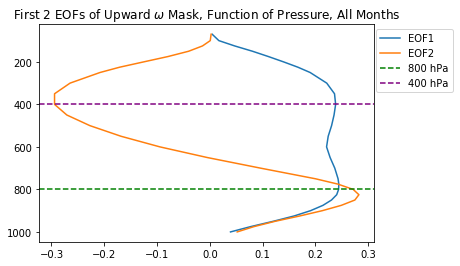

In [18]:
#plot pressure on y axis
y = np.arange(0, 28, 1)
pressure = p[y]

plot1 = plt.plot(eigvectors[:, 0], pressure, label='EOF1')
plot2 = plt.plot(eigvectors[:, 1], pressure, label='EOF2')

plt.axhline(y=800, linestyle='--', color='g', label='800 hPa')
plt.axhline(y=400, linestyle='--', color='purple', label='400 hPa')

plt.gca().invert_yaxis()

plt.title('First 2 EOFs of Upward $\omega$ Mask, Function of Pressure, All Months')
plt.legend(bbox_to_anchor=(1.25, 1.0))

plt.show()

We can see that when EOF1 and EOF2 share the same sign, there is shallow convection (the green line), and when they have opposite signs there is deep convection (the purple line). Signs don't matter so much in EOF analysis, but how signs relate to each other is important.

However, we may need to filter our signal before continuing, because EOF1 is dominating the spatial structure. When we do the analysis for the monthly subsets (DJF, MAM, etc.) this is also the case.